# Portfolio Optimisation Example

Environment representation:

- Technical indicators

Action space: Each stock represents a percentage of the portfolio holdings, sums to 1.

Reward function: Daily return.


In [ ]:
import sys

sys.path.append("..")

In [ ]:
from agents.drl_agent import DRLAgent
from config import config, config_indicators, config_models
from environments.env_portfolio_optimisation import (
    PortfolioOptimisationEnvWrapper,
)
from preprocessor.findata_preprocessor import FinancialDataPreprocessor
from visualiser.findata_visualiser import FinancialDataVisualiser
from visualiser.model_visualiser import ModelVisualiser

In [ ]:
import os

if not os.path.exists("../" + config.MODELS_DIR):
    os.makedirs("../" + config.MODELS_DIR)

if not os.path.exists("../" + config.RESULTS_DIR):
    os.makedirs("../" + config.RESULTS_DIR)

if not os.path.exists("../" + config.LOGS_DIR):
    os.makedirs("../" + config.LOGS_DIR)

In [ ]:
# If train is False, load the model from the models directory
TRAIN = False

In [ ]:
finpreprocessor = FinancialDataPreprocessor(config.START_DATE, config.END_DATE)
train_data, trade_data = finpreprocessor.load_train_test_data(
    "../" + config.DATA_DIR, config.TEST_NAME
)

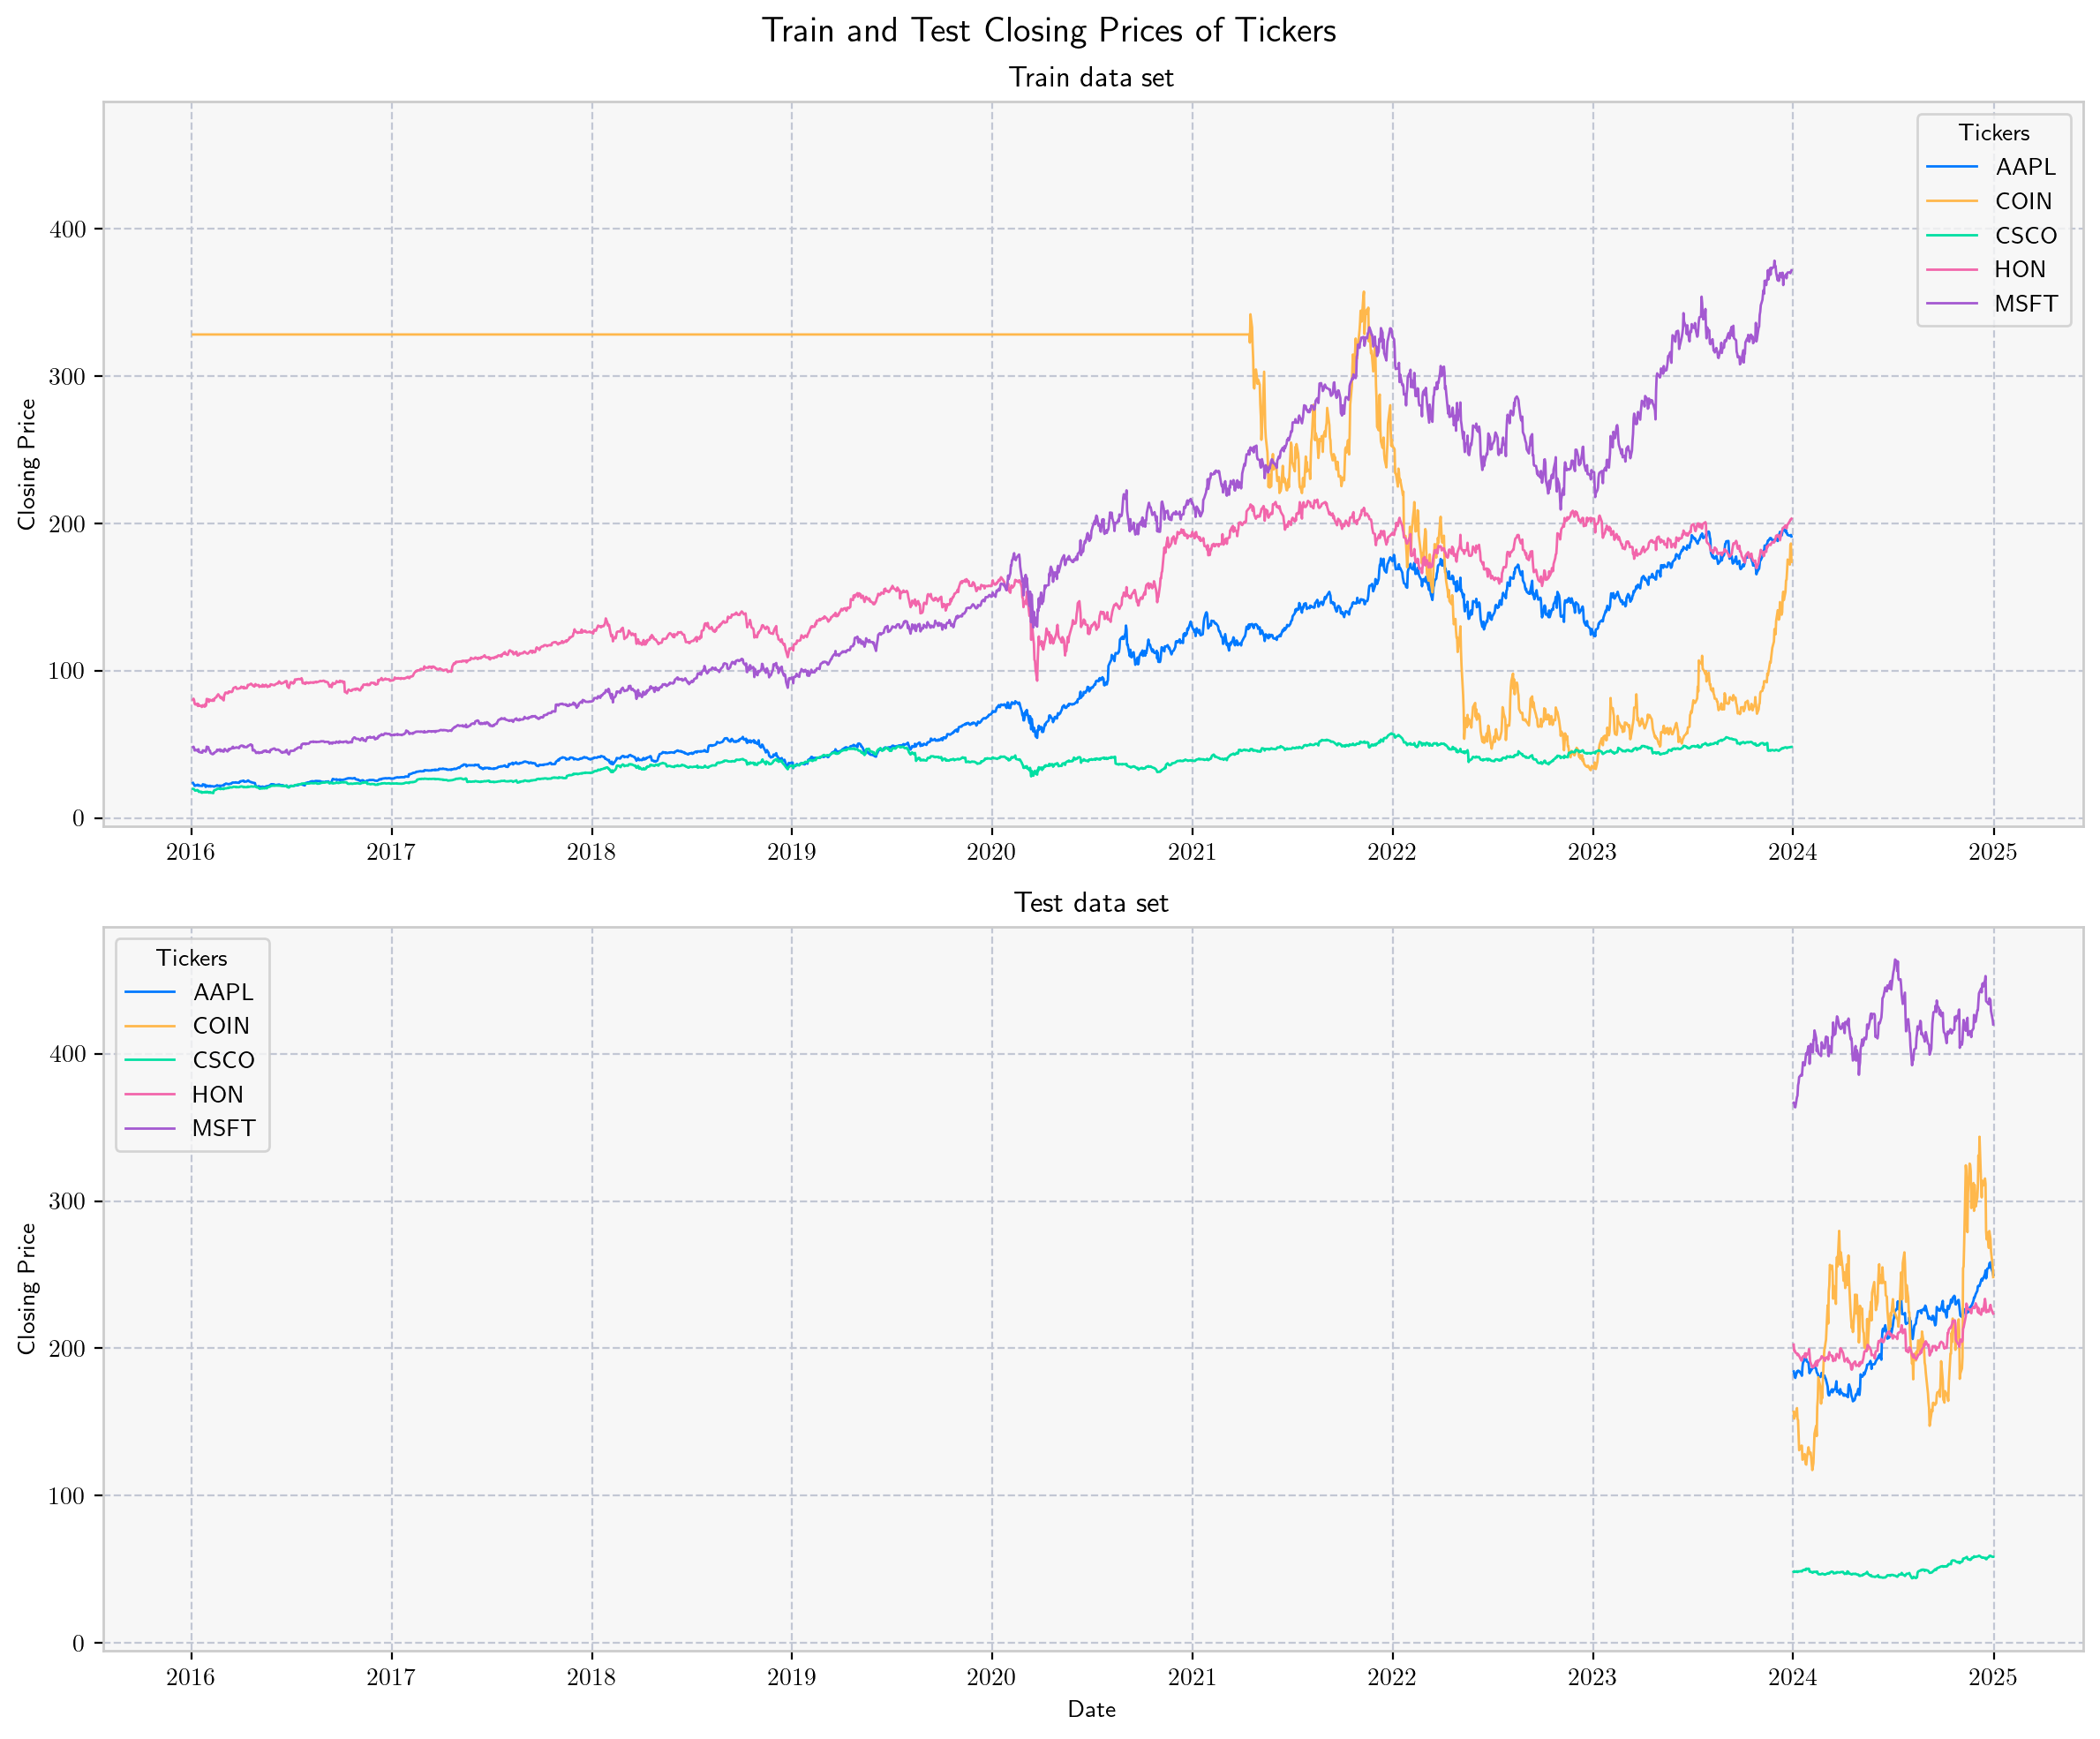

In [ ]:
finvisualiser = FinancialDataVisualiser()
finvisualiser.plot_train_test_close_prices(
    train_data, trade_data, "../" + config.PLOT_DIR, config.TEST_NAME
)

In [ ]:
environment = PortfolioOptimisationEnvWrapper(
    train_data, trade_data, list(config_indicators.TECHNICAL_INDICATORS.keys())
)

Environment successfully created with 
	Stock dimension: 5 
	State space: 16


In [ ]:
model_visualiser = ModelVisualiser()

Model arguments: {'n_steps': 10, 'ent_coef': 0.005, 'learning_rate': 0.0004}
Loading model: A2C
Model successfully loaded from ../models/portfolio-optimisation/test_a2c
Evaluating model: A2C


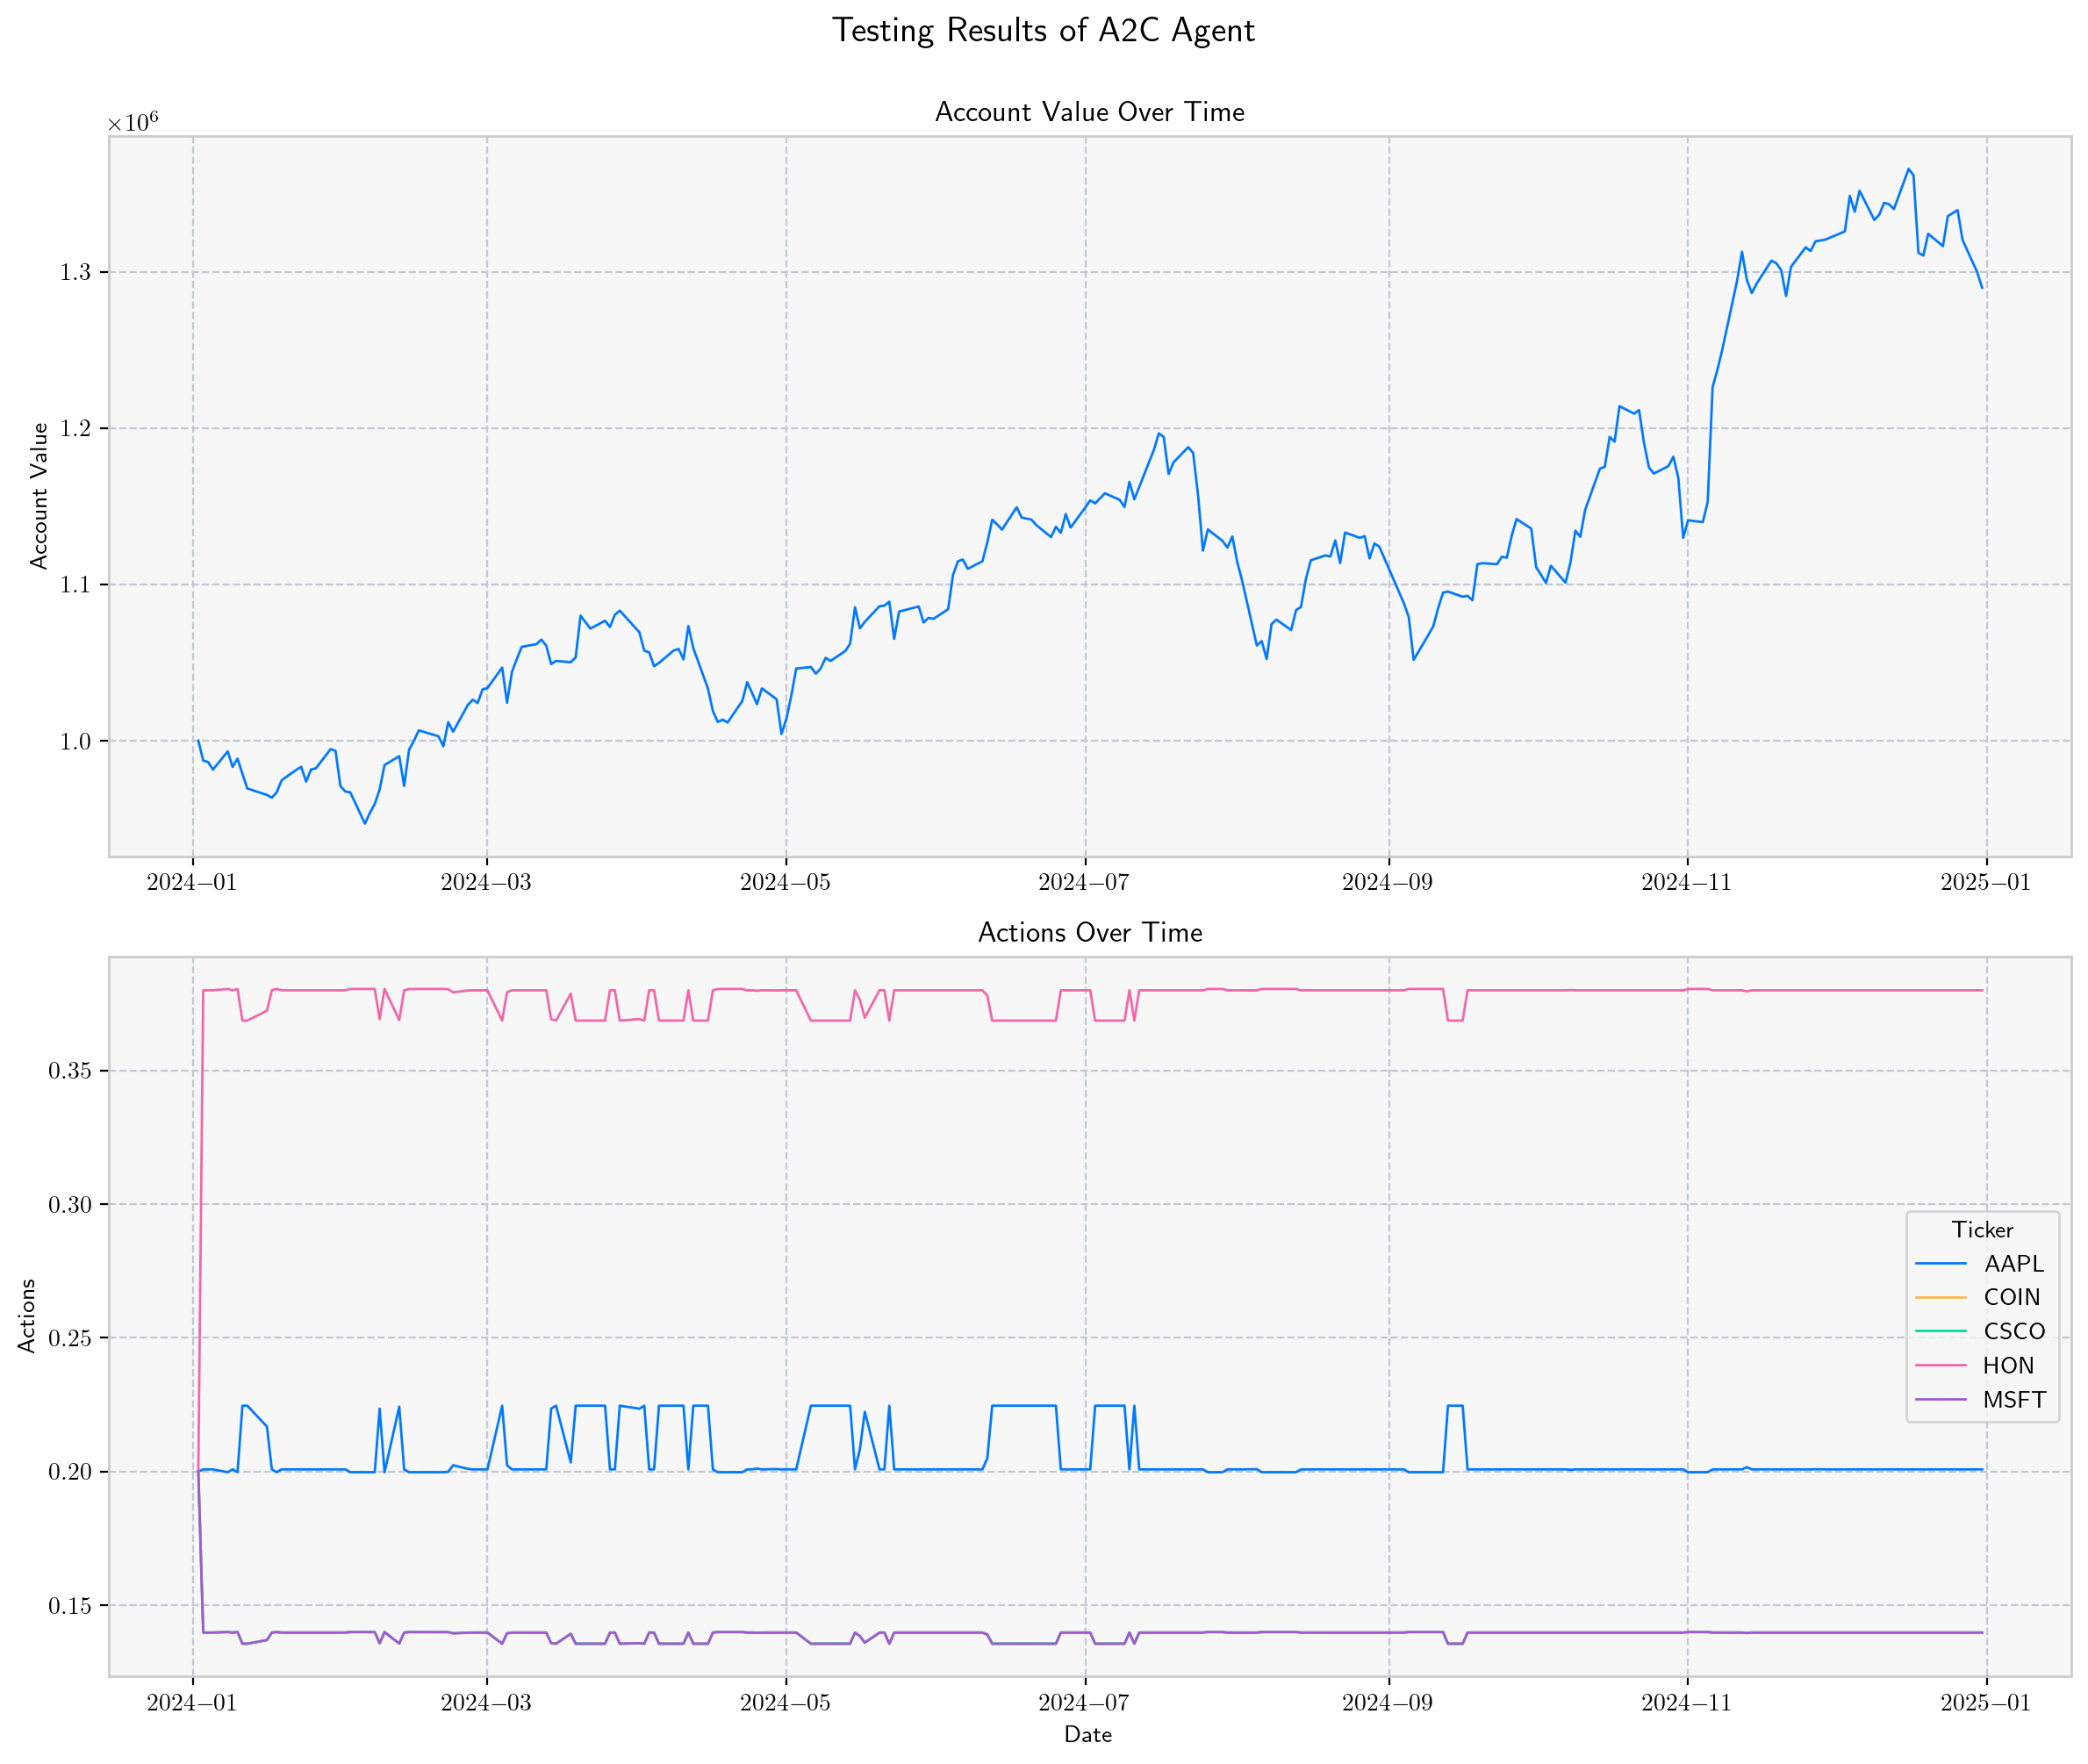

Model arguments: {'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.001, 'batch_size': 128}
Loading model: PPO
Model successfully loaded from ../models/portfolio-optimisation/test_ppo
Evaluating model: PPO


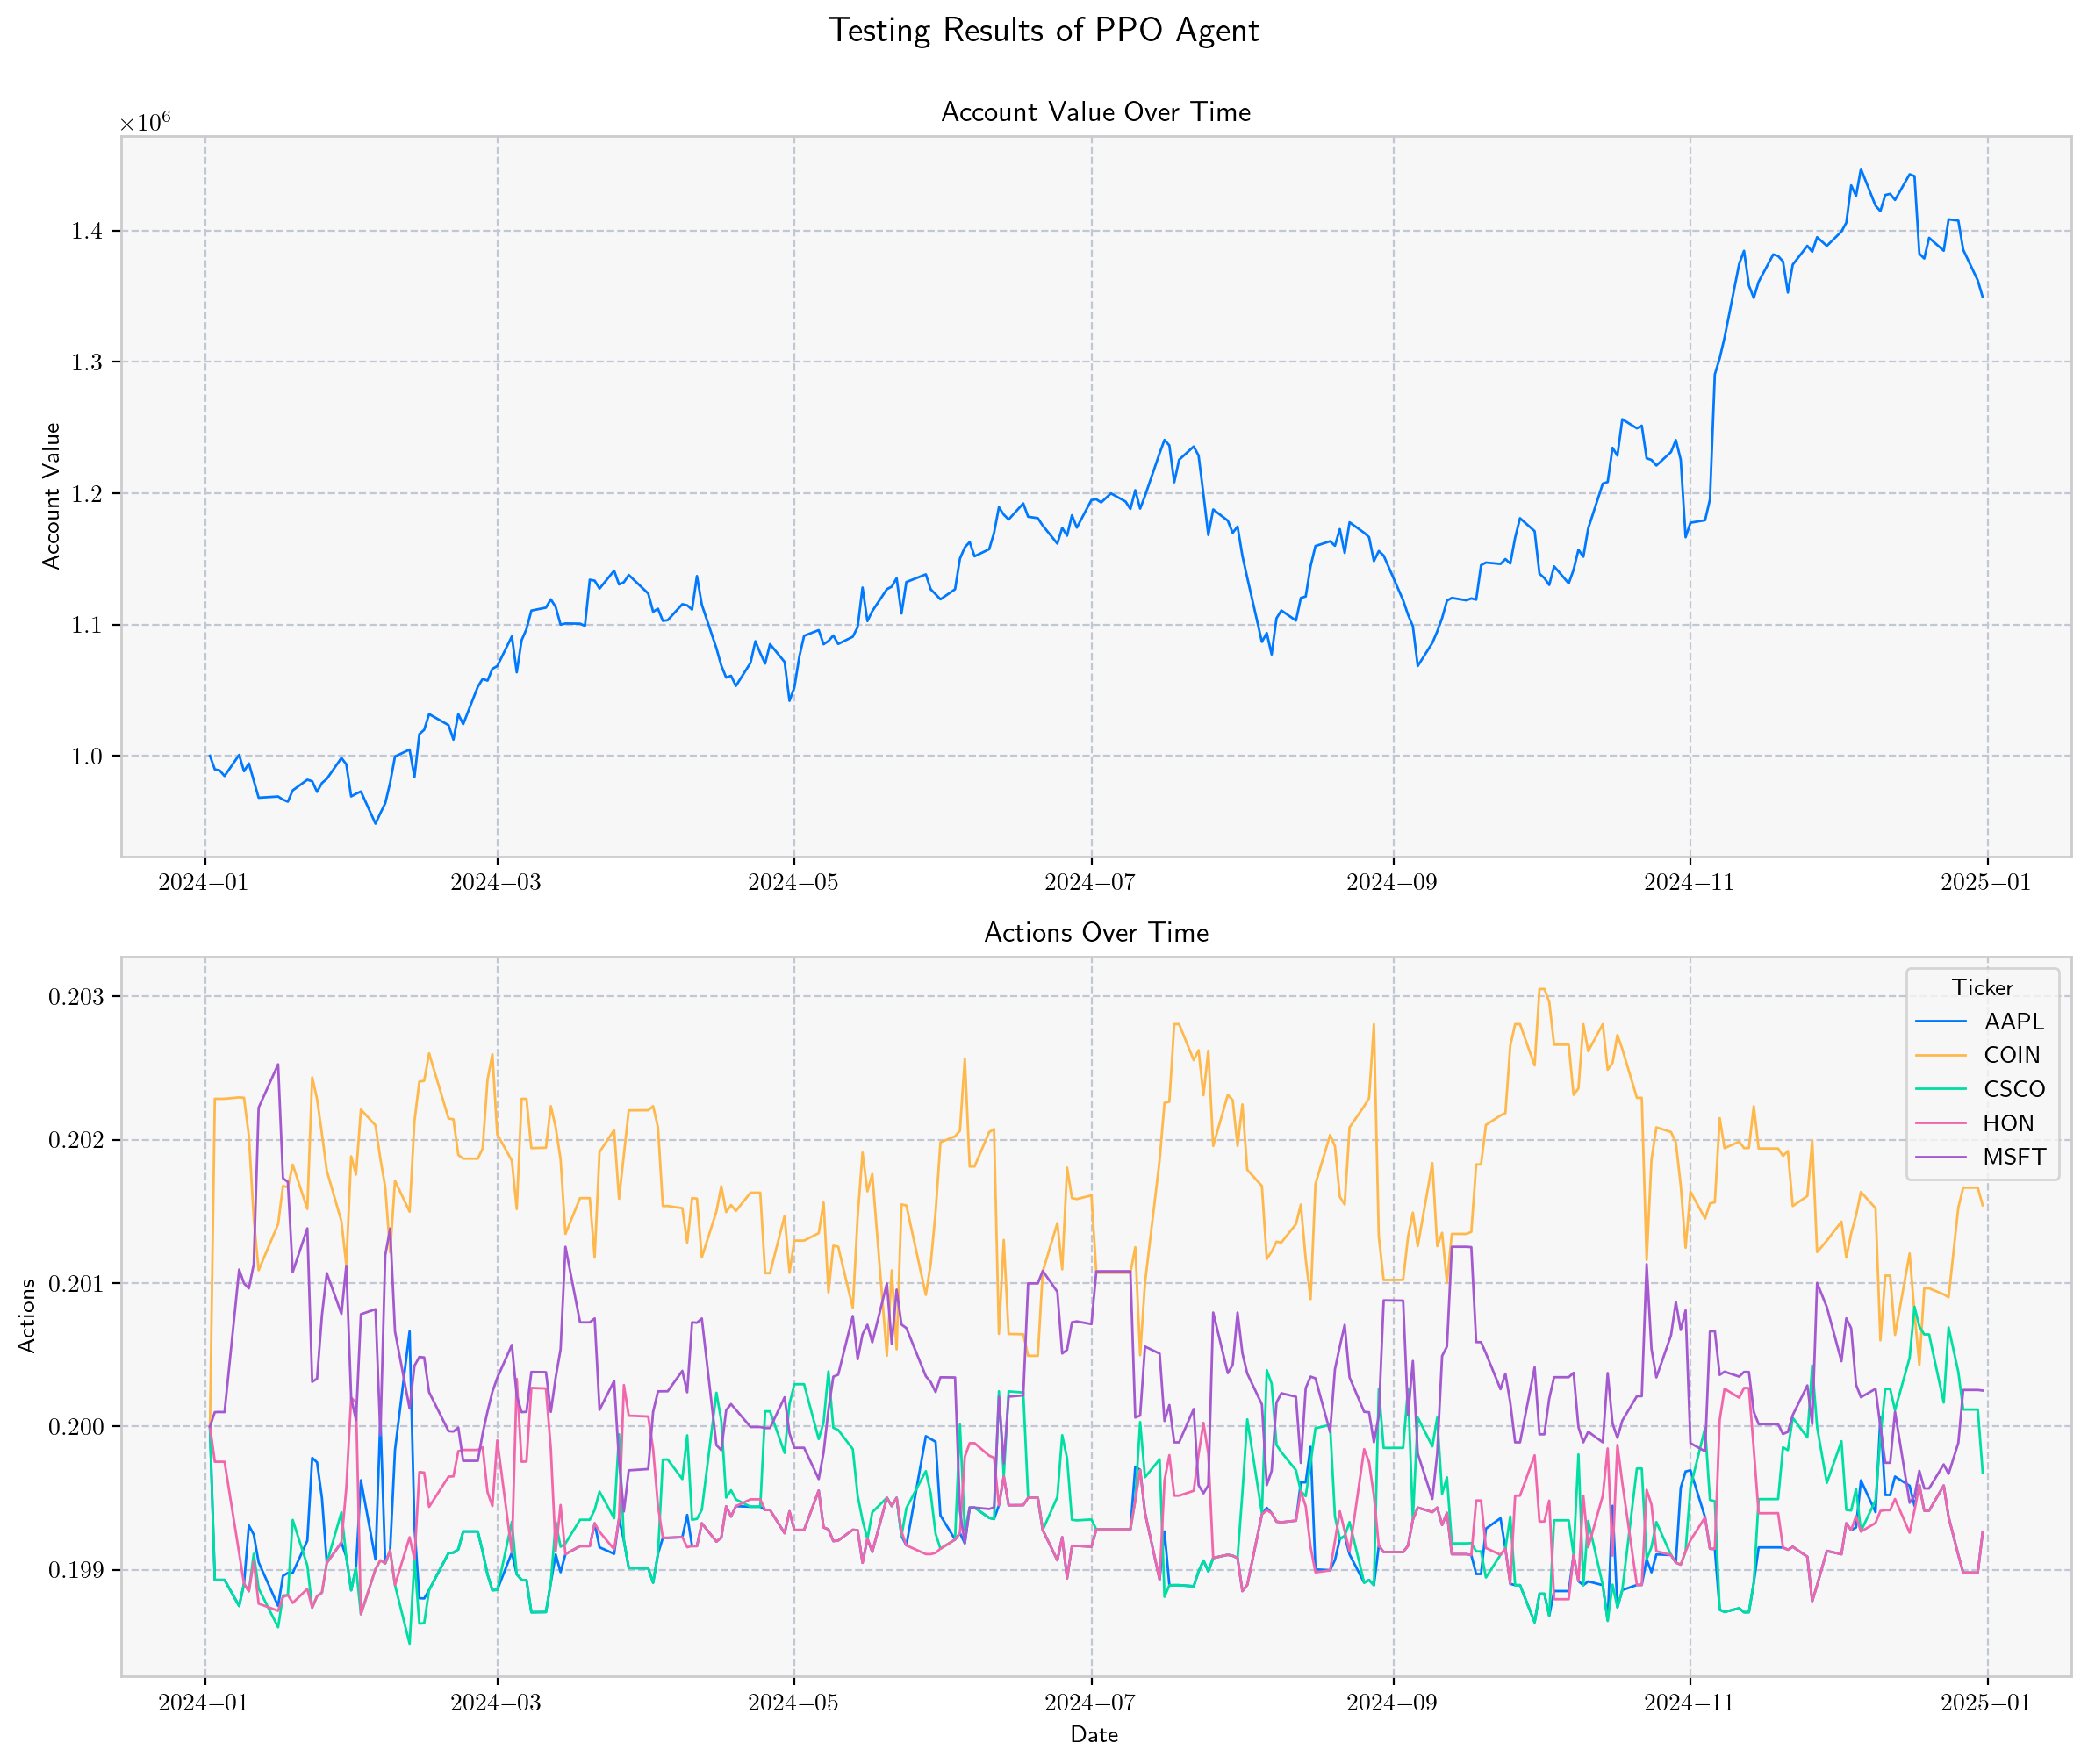

Model arguments: {'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Loading model: DDPG
Model successfully loaded from ../models/portfolio-optimisation/test_ddpg
Evaluating model: DDPG


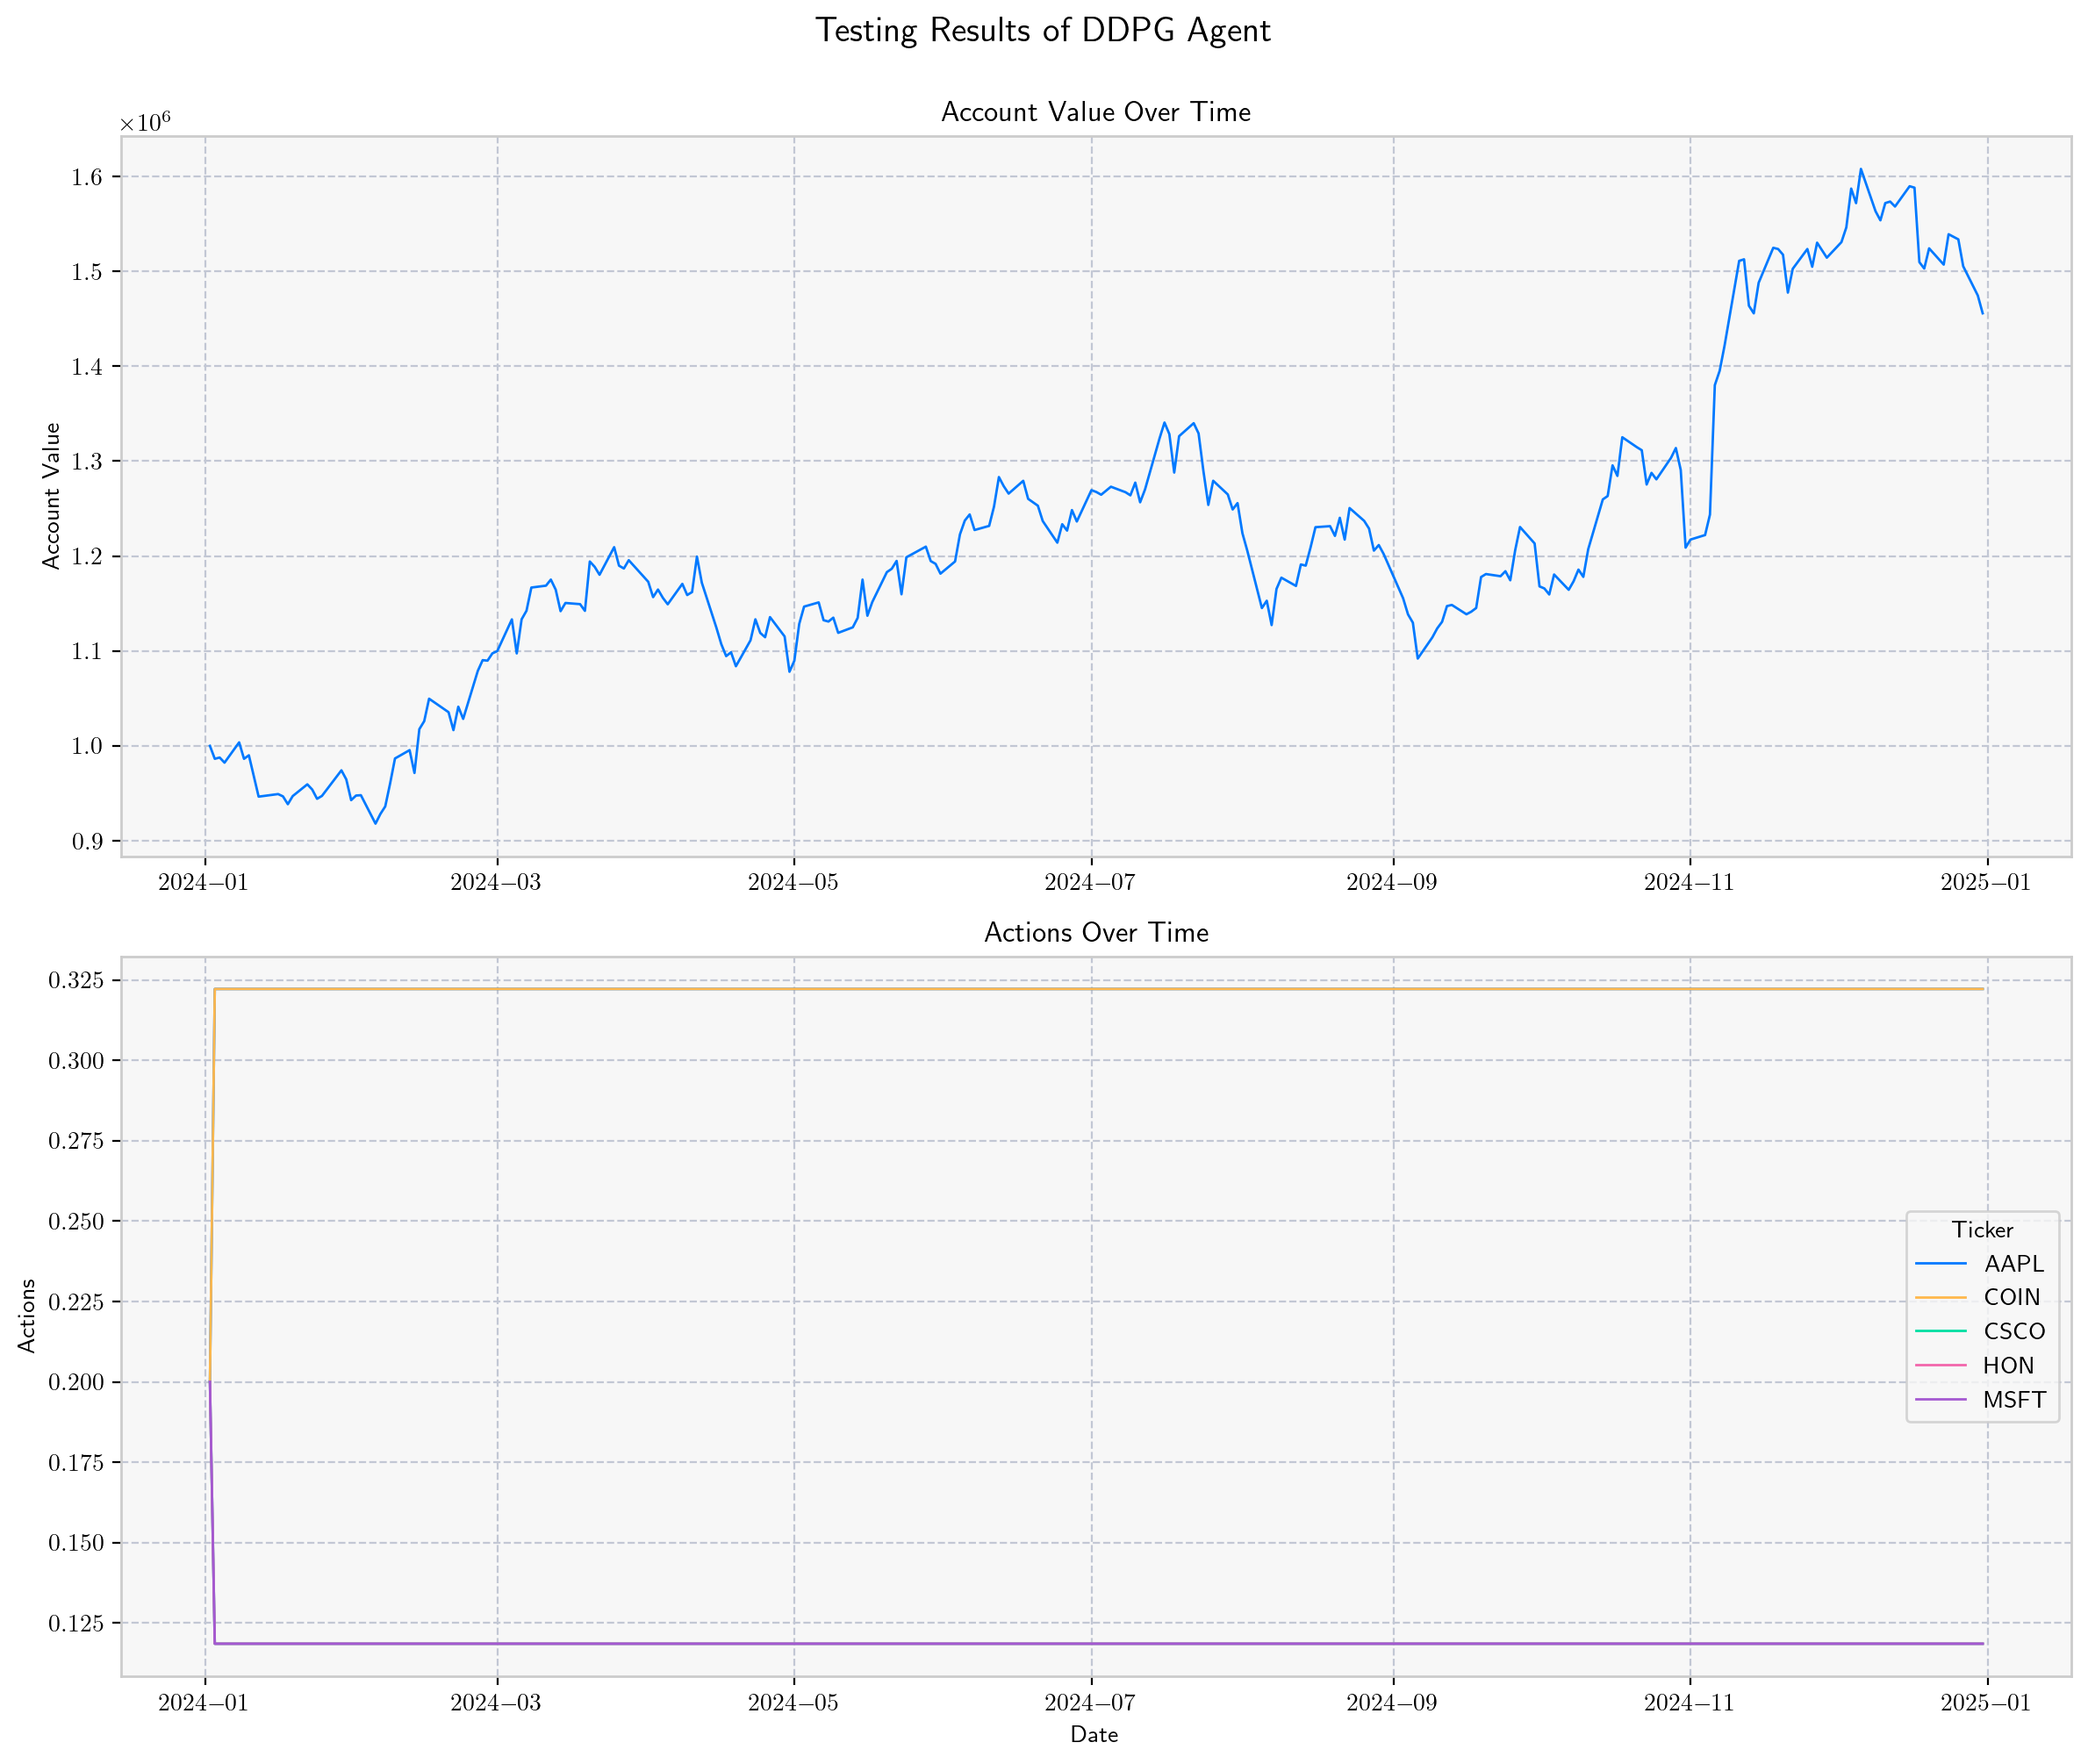

Model arguments: {'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Loading model: TD3
Model successfully loaded from ../models/portfolio-optimisation/test_td3
Evaluating model: TD3


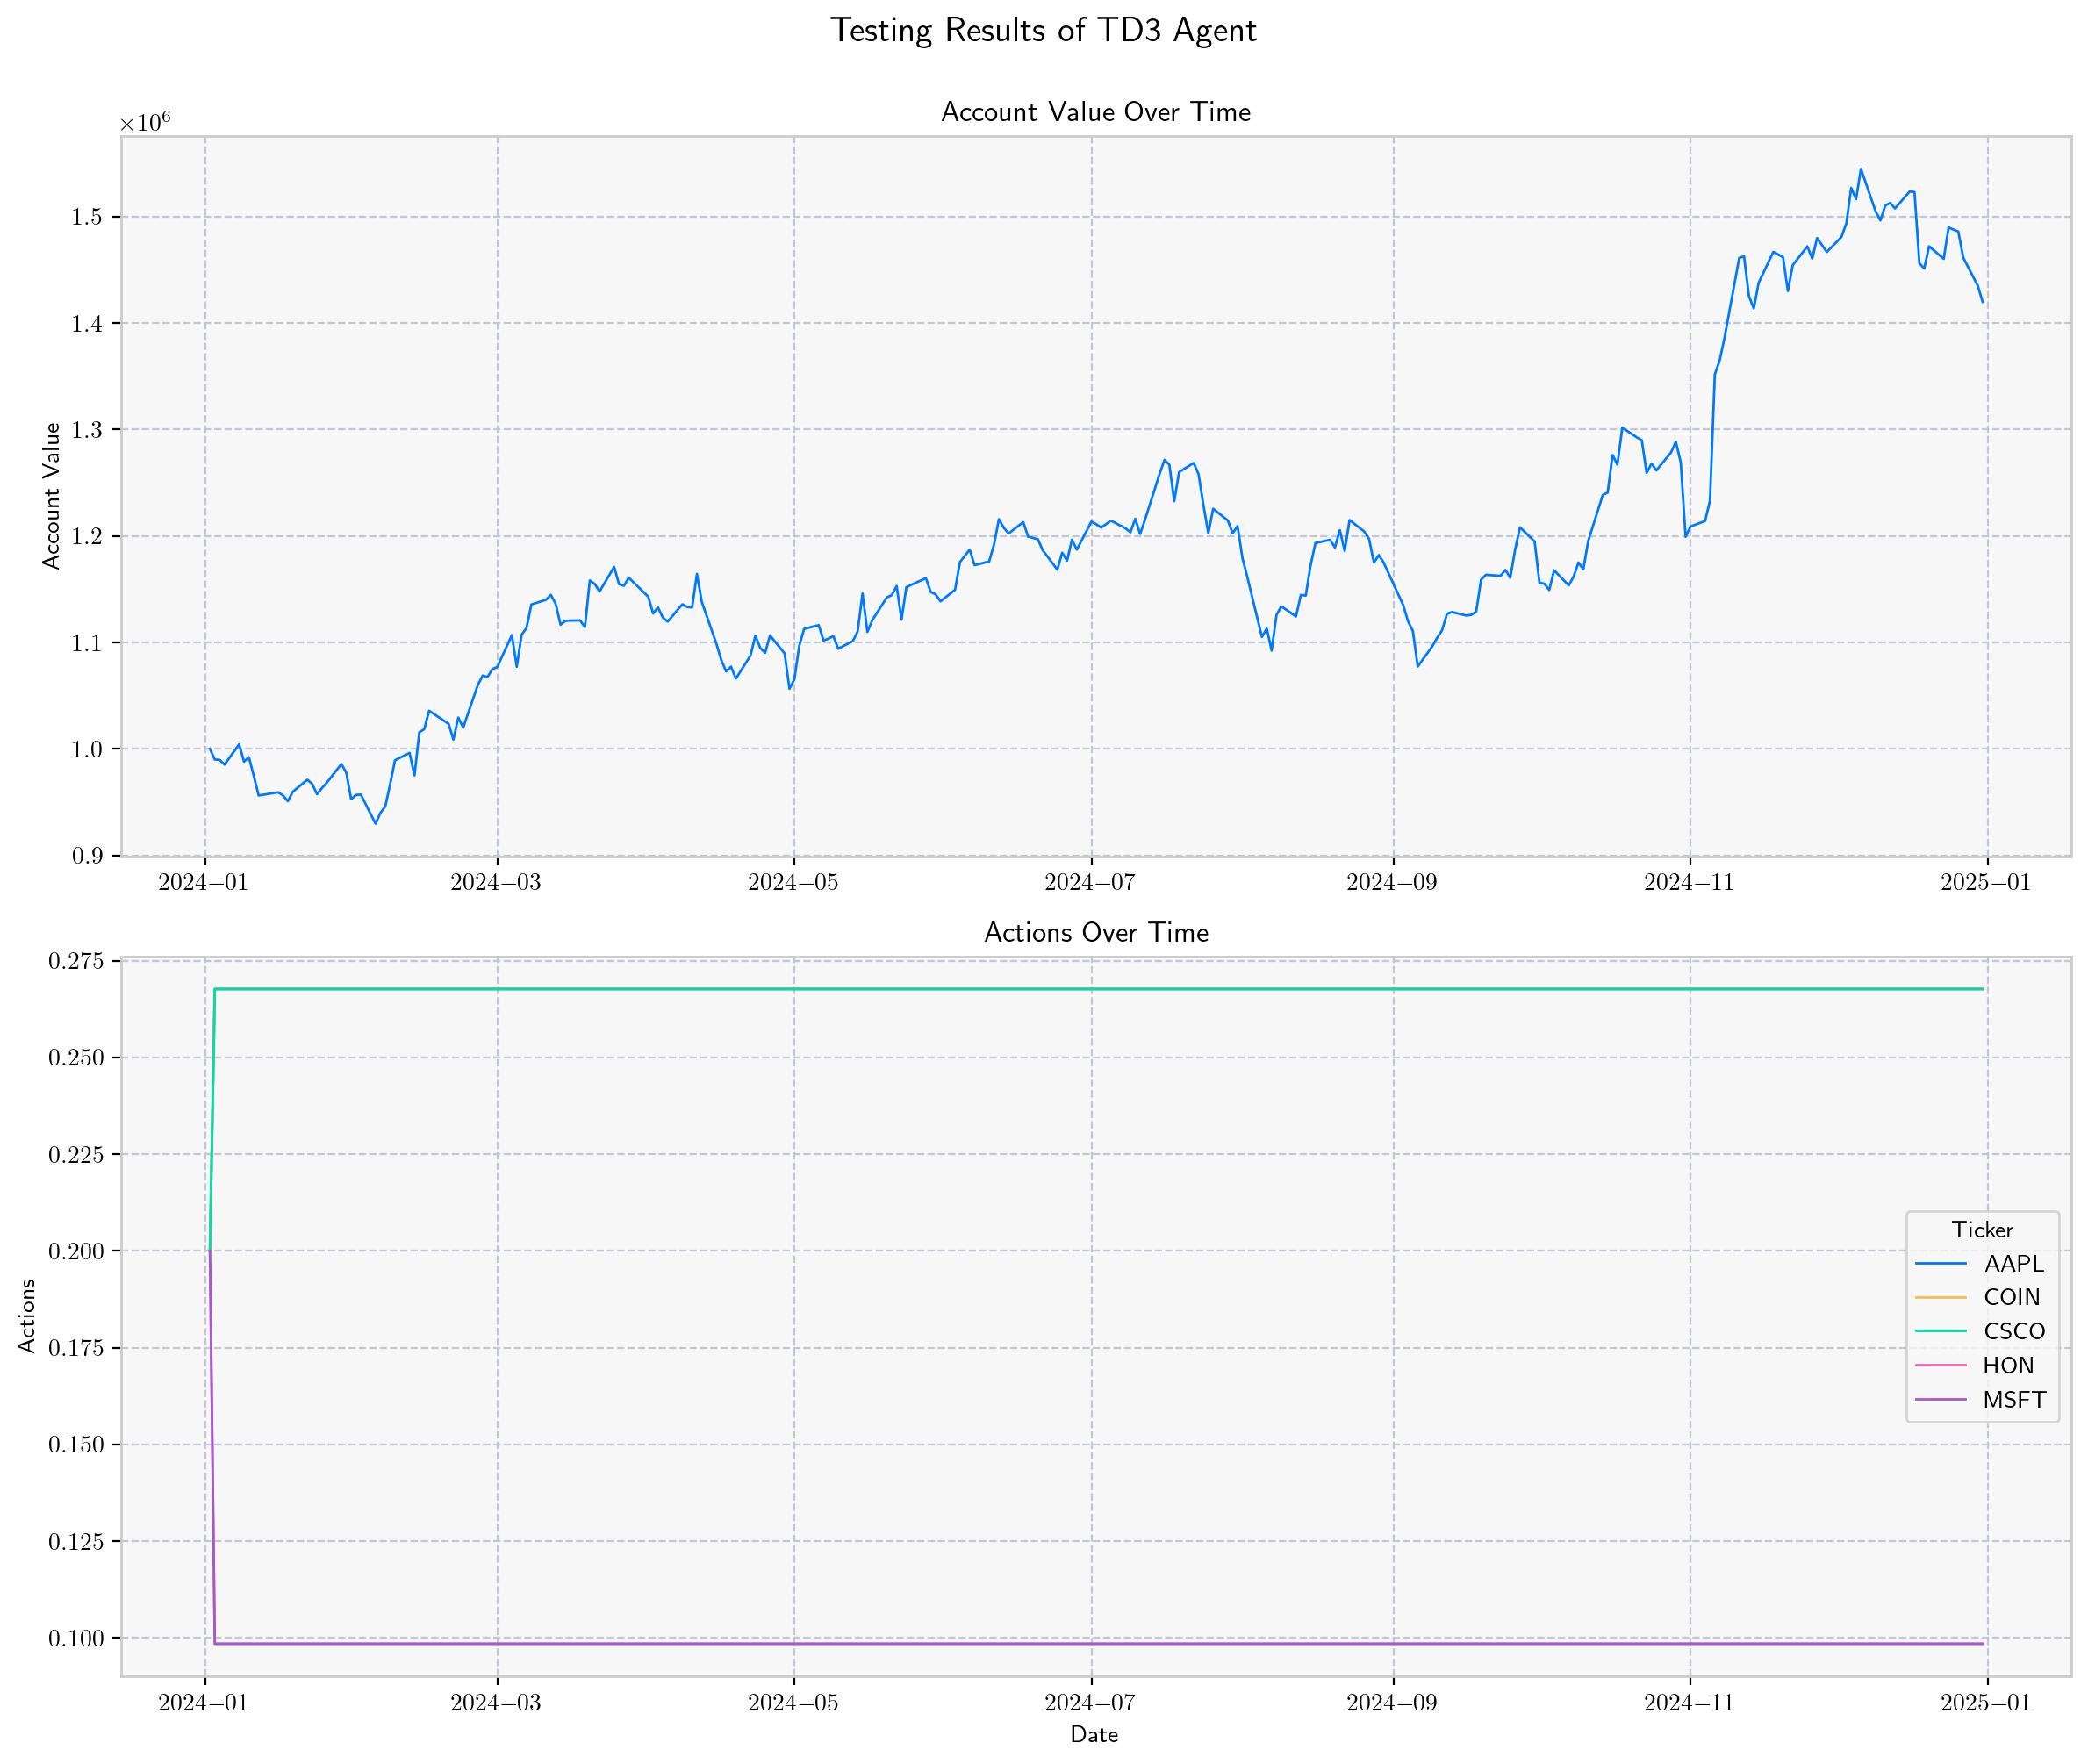

Model arguments: {'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Loading model: SAC
Model successfully loaded from ../models/portfolio-optimisation/test_sac
Evaluating model: SAC


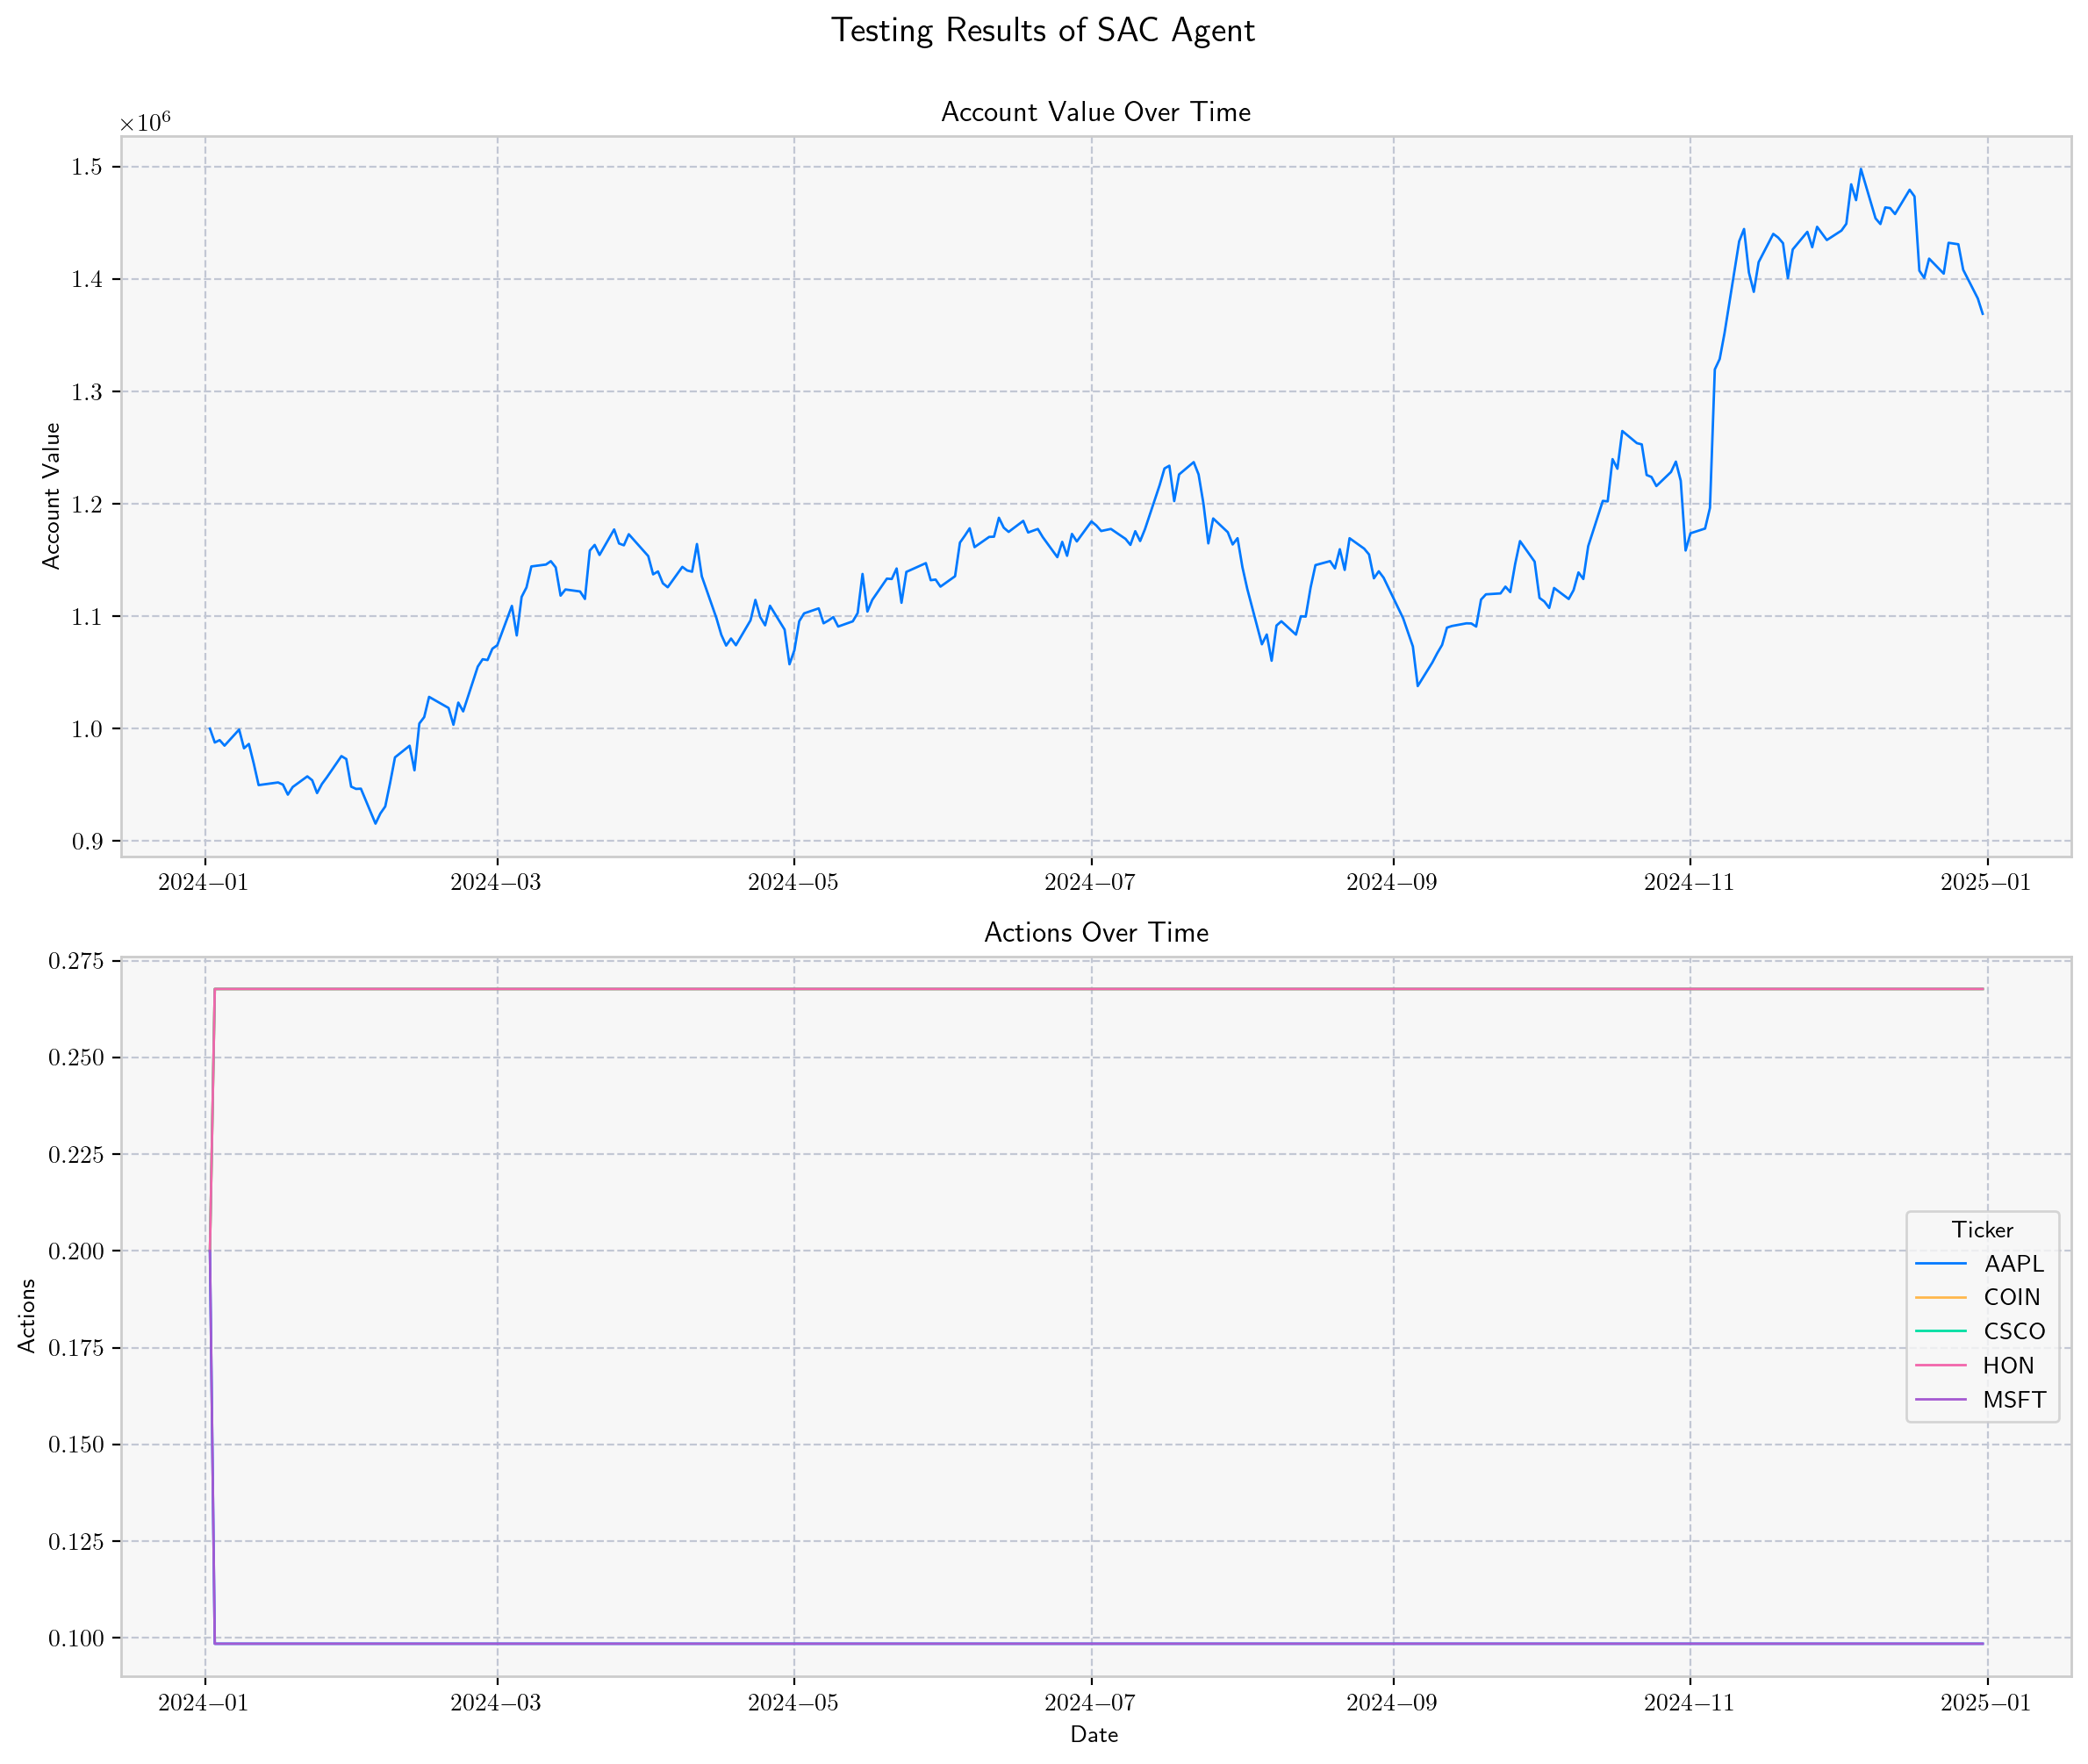

In [ ]:
for model_name in config.MODELS:

    env_train = environment.get_train_env()
    gym_env, _ = environment.get_trade_env()

    agent = DRLAgent()

    model = agent.get_model(
        model_name,
        environment=env_train,
        directory=f"../{config.LOGS_DIR}/portfolio-optimisation/{config.TEST_NAME}",
        use_case="portfolio-optimisation",
    )

    if TRAIN:
        print(f"Training model: {model_name.upper()}")
        trained_model = agent.train(
            model,
            tb_log_name=model_name,
        )
        print(f"Saving model: {model_name.upper()}")
        agent.save_model(
            model,
            model_name,
            f"../{config.MODELS_DIR}/portfolio-optimisation",
            config.TEST_NAME,
        )

        visualisation_config = config_models.train_visualisation_config[
            model_name
        ]

        model_visualiser.evaluate_training(
            model_name,
            x=visualisation_config["x"],
            y=visualisation_config["y"],
            title=visualisation_config["title"],
            logs_dir=f"../{config.LOGS_DIR}/portfolio-optimisation/{config.TEST_NAME}",
            directory=f"../{config.PLOT_DIR}/portfolio-optimisation",
            filename=config.TEST_NAME,
        )

    else:
        print(f"Loading model: {model_name.upper()}")
        trained_model = agent.load_model(
            model_name,
            f"../{config.MODELS_DIR}/portfolio-optimisation",
            config.TEST_NAME,
        )

    print(f"Evaluating model: {model_name.upper()}")
    df_account, df_actions = agent.predict(trained_model, gym_env)

    model_visualiser.evaluate_testing(
        model_name,
        df_account,
        df_actions,
        directory=f"../{config.PLOT_DIR}/portfolio-optimisation",
        filename=config.TEST_NAME,
    )